# datasets库
## 简介
> * 所有内容保存在磁盘上，使用apache arrow，即使数据集很大，也不会耗尽RAM，只有请求的元素才会加载到内存中，访问数据集的一部分
> * 包含dataset和datasetdict两个主要类，datasetdict是多个dataset的字典


In [10]:
from datasets import Dataset, DatasetDict,load_dataset
from datasets import load_from_disk
test_data = [{'text':str(i),'text_int':i,'label': 0 if i%2==0 else 1} for i in range(100)]
import jsonlines
with jsonlines.open('test_dataset.json', 'w') as writer:
    writer.write_all(test_data)

## 一. 加载数据集
> * 默认载入的是datasetdict，如果没有key，默认为train，或者可以自己定义

### 1.加载hub上的数据
> * 直接载入名称，split表示指定的key

In [ ]:
d = load_dataset("rotten_tomatoes", split="train")
# from datasets import get_dataset_split_names
# get_dataset_split_names("rotten_tomatoes")

### 2.加载本地的数据
> * CSV & TSV	csv	load_dataset("csv", data_files="my_file.csv")
> * Text files	text	load_dataset("text", data_files="my_file.txt")
> * JSON & JSON Lines	json	load_dataset("json", data_files="my_file.jsonl")
> * Pickled DataFrames	pandas	load_dataset("pandas", data_files="my_dataframe.pkl")

In [18]:
# dataset = load_dataset("json", data_files="test_dataset.json")
d = load_dataset("json", data_files={'d1':"test_dataset.json",'d2':"test_dataset.json"})
# load_dataset("text", data_dir="path/to/text/dataset")
# d = load_dataset("text", data_files={"train": "my_train_file.txt", "test": "my_test_file.txt"}, sample_by="document")

Using custom data configuration default-011997365708e9fa
Found cached dataset json (/home/zyl/.cache/huggingface/datasets/json/default-011997365708e9fa/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 524.91it/s]


### 3. 从磁盘上载入arrow数据
> * 使用时导入所有数据集 ,只有大文件才需要load-dataset的流处理，以及分析的时候才要load-dataset

In [19]:
d = load_from_disk("./test",
                   keep_in_memory=False,  # 放到内存中，会加速，否则直接磁盘映射来使用
                   # storage_options: Optional[dict] = None
                   )


FileNotFoundError: Directory ./test not found

In [16]:
d

DatasetDict({
    train: Dataset({
        features: ['text', 'text_int', 'label'],
        num_rows: 100
    })
})

## 二. 处理数据集

## 三. 保存数据集

In [ ]:


squad_it_dataset = load_dataset("json", data_files="SQuAD_it-train.json", field="data")

data_files = { "train" : "SQuAD_it-train.json" , "test" : "SQuAD_it-test.json" }
squad_it_dataset = load_dataset( "json" , data_files=data_files, field= "data" )
data_files = { "train" : "SQuAD_it-train.json.gz" , "test" : "SQuAD_it-test.json.gz" }
squad_it_dataset = load_dataset( "json" , data_files=data_files, field= "data" )

In [ ]:
# datasets集 所有内容保存在磁盘上，使用apache arrow，即使数据集很大，也不会耗尽RAM，只有请求的元素才会加载到内存中，访问数据集的一部分
from datasets import Dataset, DatasetDict
from datasets import load_from_disk

# 1. 每组数据处理成list或generator形式--外部处理 ，注意要去重和删除错误数据
def my_gen(labels_cls):
    for i in range(1, 100):
        if i % 2 == 0:
            l = labels_cls['not']
        else:
            l = labels_cls['yes']
        yield {"a": i + 2,
               'b': l,
               'c': str(i),
               # 'd':[i+3,str(i)], 列表报错
               'e': {'text': str(i), 'num': i}
               }


# 2. 各个数据集构建
labels_cls = {'not': 'double', 'yes': 'not_double'}
d = Dataset.from_generator(generator=my_gen,
                           # features= my_features,  # 特征Features 自定义
                           cache_dir="/large_files/5T/huggingface_cache",  # cache路径
                           keep_in_memory=False,  # 是否存进内存
                           gen_kwargs={'labels_cls': labels_cls},  # 生成器的参数
                           num_proc=3,  # 存储和读取时的多进程数
                           )
# 3. 各个数据集的处理,注意保存原始的数据，
d.cleanup_cache_files()  # 清理目录中的缓存文件
d = d.shuffle(seed=42)  # 重排
# small_train_dataset = d["train"].shuffle(seed=42).select(range(1000))
# small_eval_dataset = d["test"].shuffle(seed=42).select(range(1000))
d = d.rename_columns({"sentence1": "sentenceA"})  # 重命名
d = d.remove_columns(["sentence1", "sentence2"])  # 删除列


label2id = {"contradiction": 0, "neutral": 1, "entailment": 2}
d = d.align_labels_with_mapping(label2id, "label")  # 标签映射


def add_prefix(example):
    example["sentence1"] = 'My sentence: ' + example["sentence1"]
    return example

# 推荐map操作，加速,map类似字典，根据需要添加新列或更新现有的列，由于rust，map可以使用batched
tokenized_datasets = d.map(add_prefix, batched=True)
# 注意函数里面返回的是一个dict,是对之前的数据集进行添加操作，而且输入输出的长度可以不一样，用于数据增强，还可以分布式，拆分，多进程处理,
d = d.with_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])  # 切换数据类型
# def encode(batch):
#     return tokenizer(batch["sentence1"], padding="longest", truncation=True, max_length=512, return_tensors="pt")
# d.set_transform(encode) # 只在访问这个实例的时候作用
small_train_dataset = d.select(range(100))  # 使用select选择指定的文本
train_dataset, validation_dataset = d.train_test_split(test_size=0.1).values()  # 切分数据

# 4. 各个数据集信息的增加
d['train'].info.update(d['train'].info.from_dict({"description": 'a'}))

# 5.合并多个数据集,构建成dict
d = DatasetDict({'train': train_dataset, 'val': validation_dataset})

# 6.存储处理的所有数据集--arrow格式
d.save_to_disk("./test",
               # max_shard_size: Optional[Union[str, int]] = None,
               # num_shards: Optional[int] = None,
               num_proc=3,
               # storage_options: Optional[dict] = None,
               )  # 每个数据集包括：dict.json / state.json  / info.json

# # 7.使用时导入所有数据集 ,只有大文件才需要load-dataset的流处理，以及分析的时候才要load-dataset
d = load_from_disk("./test",
                   keep_in_memory=False,  # 放到内存中，会加速，否则直接磁盘映射来使用
                   # storage_options: Optional[dict] = None
                   )

# 另外：数据的分析
# d.to_json('test/train/sad.json')  # jsonl，只有dataset可以用
# load_dataset('json','test/train/sad.json')  # jsonl
# dataset.features  #提供基本信息
# dataset.sort("label")  # 排序
# dataset.select([0, 10, 20, 30, 40, 50])  # 选择
# dataset.filter(lambda example: example["sentence1"].startswith("Ar")  # 过滤
# dataset.flatten() # 铺平特征
# dataset.cast(new_features) # 切换特征
# concatenate_datasets([bookcorpus, wiki],axis=0)  # 合并dataset
# interleave_datasets([d1, d2, d3], probabilities=probabilities, seed=seed)  # 交叉合并
# dataset.reset_format()   # 重置类型
# dataset.info  # 信息
# # 切片/索引，index的索引比column的索引快
# dataset.push_to_hub( "stevhliu/processed_demo" )


# 封装数据成包
# samples = d['train'][:8]
# from transformers import DataCollatorWithPadding
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# batch = data_collator(samples)




In [ ]:
ds.set_format("pt")

seq_len, dataset_size = 512, 512
dummy_data = {
    "input_ids": np.random.randint(100, 30000, (dataset_size, seq_len)),
    "labels": np.random.randint(0, 1, (dataset_size)),
}
ds = Dataset.from_dict(dummy_data)
ds.set_format("pt")


In [ ]:
new_dataset = my_dataset.map(my_processing_func, batched=True, fn_kwargs={"model": model, "tokenizer": tokenizer})

In [ ]:
from functools import partial
new_dataset = my_dataset.map(partial(my_processing_func, model=model, tokenizer=tokenizer), batched=True)

In [ ]:
def add_dataset_to_dataset_dict(dataset,dataset_dict_file,split_name):
    if not os.path.exists(dataset_dict_file):
        os.mkdir(dataset_dict_file)
        save_data({'splits':[split_name]}, os.path.join(dataset_dict_file, 'dataset_dict.json'), 'json')
    dataset.save_to_disk(os.path.join(dataset_dict_file,split_name))
    dataset_dict_config = load_data(os.path.join(dataset_dict_file,'dataset_dict.json'),'json')
    if split_name not in dataset_dict_config.get('splits',[]):
        if 'splits' not in dataset_dict_config:
            dataset_dict_config['splits'] = []
        dataset_dict_config['splits'].append(split_name)
    save_data(dataset_dict_config,os.path.join(dataset_dict_file,'dataset_dict.json'),'json')


In [ ]:
def get_hash(example):
    """Get hash of content field."""
    return {"hash": hashlib.md5(example["text"].strip().encode("utf-8")).hexdigest()}

def check_uniques(example, uniques):
    """Check if current hash is still in set of unique hashes and remove if true."""
    if example["hash"] in uniques:
        uniques.remove(example["hash"])
        return True
    else:
        return False

def preprocess(example):
    """Chain all preprocessing steps into one function to not fill cache."""
    results = dict()
    results.update(get_hash(example))
    return results

def filter(example, unique):
    """Filter dataset with heuristics. Config, test and has_no_keywords files are removed with a given probability."""
    if not check_uniques(example, uniques):
        return False
    else:
        return True

# Load dataset
ds = load_dataset(dataset_name, split="train")

# Run preprocessing
ds = ds.map(preprocess, num_proc=num_workers)

# Deduplicate hashes
uniques = set(ds.unique("hash"))

# Deduplicate data and apply heuristics
ds_filter = ds.filter(filter, fn_kwargs={"uniques": uniques})

https://blog.csdn.net/yaohaishen/article/details/123702163
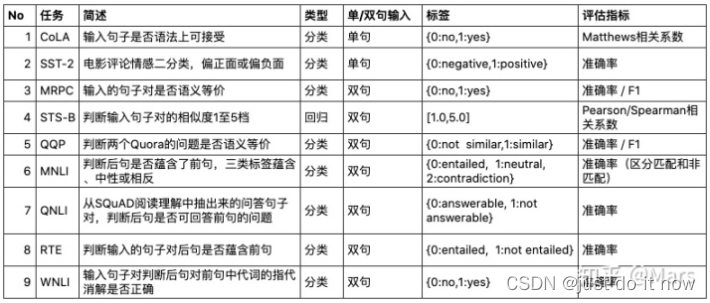